In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from topicpy.hsbmpy import fraction_bar_plot, get_max_available_L
from topicpy.geneontology import get_symbol
from tableanalyser import get_ensg, get_symbol
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
directory = r'datasets/tcga/BRCA/mirna/'
l=get_max_available_L(directory, "topsbm")

In [14]:
import multiprocessing as mp

df = pd.DataFrame()

def get_series(line):
    data = line.split("\t")
    if len(data) < 2:
        return pd.Series(dtype=int)
    return pd.Series(index = data[2:], name = data[0], data = np.repeat(1, len(data)-2).astype(int), dtype=int)

def join_series(series):
    global df
    if series is not None:
        df = df.join(series, how="outer").fillna(0).astype(int)

pool = mp.Pool()
with open("MSigDB/c3.all.v7.1.symbols.gmt", "r") as file:
    work = pool.map_async(get_series, file.read().split("\n"), callback=join_series, error_callback=lambda err: print(err))
    
pool.close()
pool.join()

In [15]:
df

,AAANWWTGC_UNKNOWN,AAAYRNCTG_UNKNOWN,MYOD_01,E47_01,CMYB_01,AP4_01,AACTTT_UNKNOWN,MEF2_01,ELK1_01,SP1_01,...,MIR451A,MIR574_3P,MIR4749_5P,MIR6741_3P,MIR4638_5P,MIR6790_3P,MIR4440,LET_7I_3P,CTTTGT_LEF1_Q2,0
MEF2C,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
ATP1B1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
RORA,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CITED2,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
APP,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEX51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KRTAP5-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CSTL1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SPATA31E1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
df.sum()

AAANWWTGC_UNKNOWN     194
AAAYRNCTG_UNKNOWN     374
MYOD_01               269
E47_01                254
CMYB_01               253
                     ... 
MIR6790_3P              5
MIR4440                 5
LET_7I_3P               5
CTTTGT_LEF1_Q2       1983
0                       0
Length: 3736, dtype: int64

In [17]:
genes = pd.read_csv("gene_symbol.txt", index_col=0)
genes

,Description
ENSG00000223972,DDX11L1
ENSG00000227232,WASH7P
ENSG00000243485,MIR1302-11
ENSG00000237613,FAM138A
ENSG00000268020,OR4G4P
...,...
ENSG00000198695,MT-ND6
ENSG00000210194,MT-TE
ENSG00000198727,MT-CYB
ENSG00000210195,MT-TT


In [18]:
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topics.csv"%(directory,l))
df_topic_distr = pd.read_csv("%s/topsbm/topsbm_level_%d_word-dist.csv"%(directory,l), index_col=0)

In [19]:
topic_tf = pd.DataFrame(index=df.columns)
for topic in df_topics.columns:
    print(topic)
    #get P(gene|topic) with symbols
    subdf = df_topic_distr[topic][df_topic_distr[topic]>0]
    subdf.reindex(index=np.unique([get_symbol(e) for e in subdf.index]))
    #get TF for current genes
    cdf = df[df.index.isin(list(map(get_symbol, subdf.index)))].astype(float)
    #weight TF for probability
    cdf.multiply(subdf, axis=0).fillna(0.)
    #sum # of TF
    c_series = cdf.apply(lambda x: np.sum(x.astype(float)), axis=0)
    topic_tf.insert(0, topic, c_series)

Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9
Topic 10
Topic 11
Topic 12
Topic 13
Topic 14
Topic 15
Topic 16


In [47]:
mask = topic_tf.sum(1) > 180

In [48]:
fraction_tf = topic_tf[mask].fillna(0).transpose()
#fraction_tf=fraction_tf.divide(fraction_tf.sum(axis=1), axis=0).fillna(0)
fraction_tf = fraction_tf.to_dict('list')

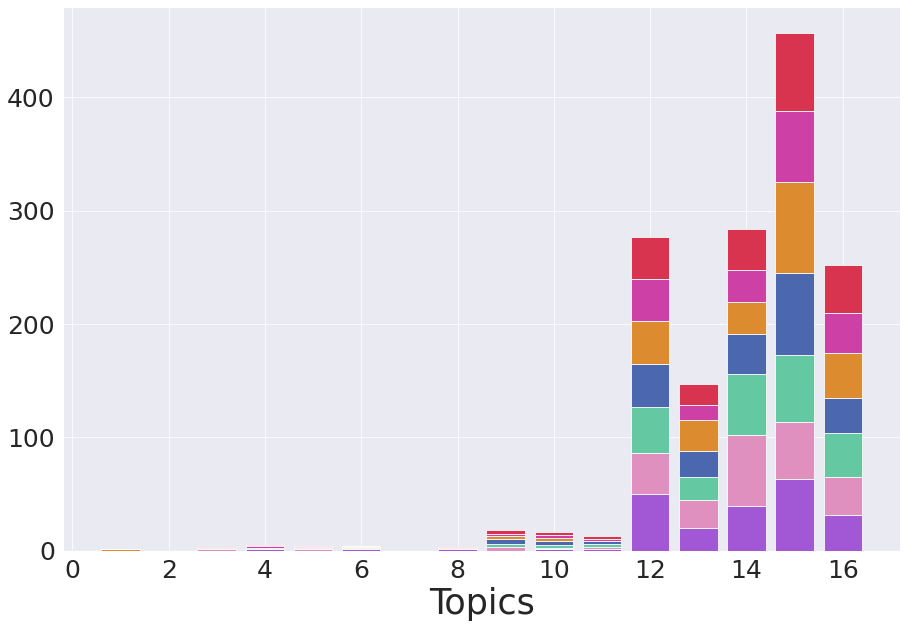

In [49]:
fig=plt.figure(figsize=(15,10))
ax=fig.subplots()
x = np.arange(1,1+len(df_topics.columns))
fraction_bar_plot(x, fraction_tf, ax)
ax.tick_params(labelsize=25)
ax.set_xlabel("Topics", fontsize=35)
#plt.yscale('log')
#plt.legend(ncol=20)
plt.show()